# Laplacian segmentation

This notebook implements the laplacian segmentation method of [McFee and Ellis, 2014](http://bmcfee.github.io/papers/ismir2014_spectral.pdf), with a couple of minor stability improvements.

In [1]:
from __future__ import print_function

In [2]:
import librosa
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.cluster

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [3]:
y, sr = librosa.load('audio/Karissa_Hobbs_-_09_-_Lets_Go_Fishin.mp3')

In [4]:
C = librosa.logamplitude(np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3, real=False))**2,
                         ref_power=np.max)

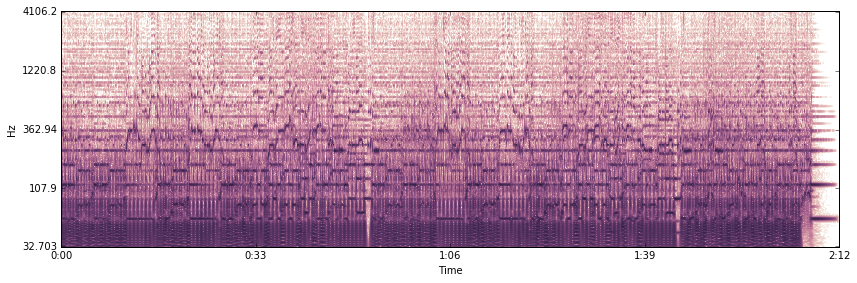

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr, bins_per_octave=12*3, x_axis='time')
plt.tight_layout()

In [6]:
# Let's beat-synchronize this to reduce dimensionality
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
Csync = librosa.util.sync(C, beats, aggregate=np.median)

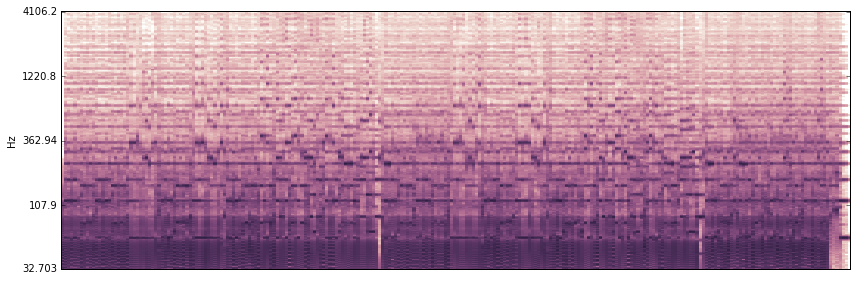

In [7]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(Csync, bins_per_octave=12*3, y_axis='cqt_hz')
plt.tight_layout()

In [8]:
# Let's build a weighted recurrence matrix from this
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity', sym=True)

In [9]:
# And enhance diagonals with a median filter
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 5))

In [10]:
# Now let's build the sequence matrix using mfcc-similarity
# R_path[i, i+] = exp(-|C_i - C_j|^2 / bw)
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
bw = np.mean(path_distance)
path_sim = np.exp(-path_distance / bw)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

In [11]:
# And compute the balanced combination

deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path

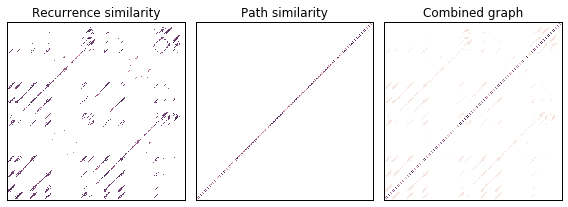

In [12]:
plt.figure(figsize=(8, 4))
plt.subplot(1,3,1)
librosa.display.specshow(Rf, aspect='equal')
plt.title('Recurrence similarity')
plt.subplot(1,3,2)
librosa.display.specshow(R_path, aspect='equal')
plt.title('Path similarity')
plt.subplot(1,3,3)
librosa.display.specshow(A, aspect='equal')
plt.title('Combined graph')
plt.tight_layout()

In [13]:
# Now let's compute the symmetric normalized laplacian
L = scipy.sparse.csgraph.laplacian(A, normed=True)

In [42]:
# And its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)

In [43]:
# We can clean this up further with a median filter.
# This can help smooth over brief discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(15, 1))

In [72]:
# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how segment changes as you vary k

k = 5

X = evecs[:, :k] / Cnorm[:, k:k+1]

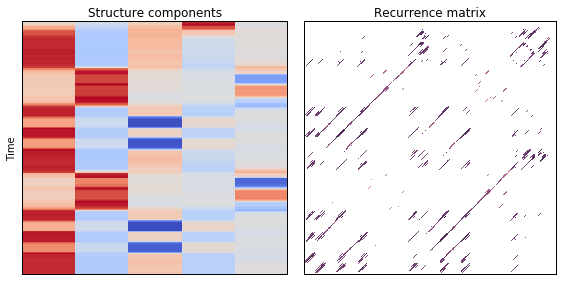

In [73]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,2)
librosa.display.specshow(Rf, aspect='equal')
plt.title('Recurrence matrix')

plt.subplot(1,2,1)
librosa.display.specshow(X)
plt.title('Structure components')
plt.ylabel('Time')
plt.tight_layout()

In [74]:
# Let's use these k components to cluster
KM = sklearn.cluster.KMeans(n_clusters=k)

seg_ids = KM.fit_predict(X)

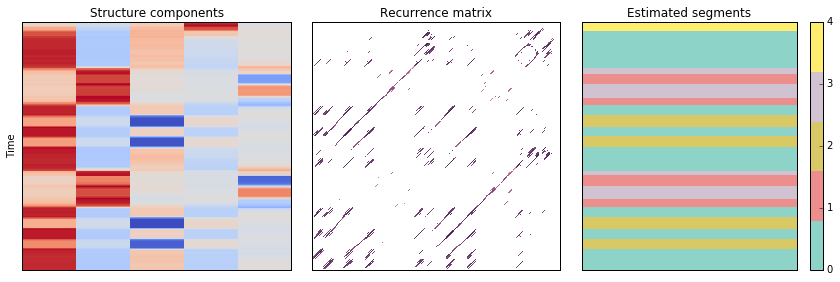

In [75]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,2)
librosa.display.specshow(Rf, aspect='equal')
plt.title('Recurrence matrix')
plt.subplot(1,3,1)
librosa.display.specshow(X)
plt.title('Structure components')
plt.ylabel('Time')
plt.subplot(1,3,3)
librosa.display.specshow(np.atleast_2d(seg_ids).T, cmap=plt.get_cmap('Set3', k))
plt.title('Estimated segments')
plt.colorbar(ticks=range(k))
plt.tight_layout()

In [76]:
# Convert the segment ids back to indices of segment boundaries
bound_beats = np.flatnonzero(seg_ids[1:] != seg_ids[:-1])

In [77]:
# Convert beat indices to frames
bound_frames = beats[bound_beats]

# Pad this out to cover the beginning and end of the track
bound_frames = librosa.util.fix_frames(bound_frames, x_min=0, x_max=beats.max())

# And convert to time
bound_times = librosa.frames_to_time(bound_frames)

In [78]:
bound_times

array([   0.        ,   10.77405896,   16.69514739,   21.75709751,
         27.7014059 ,   32.78657596,   37.03582766,   44.14113379,
         49.73714286,   51.75727891,   63.97097506,   70.07782313,
         74.6521542 ,   80.75900227,   85.84417234,   89.55936508,
         97.1755102 ,  102.44643991,  105.51147392,  124.83047619,
        129.45124717])

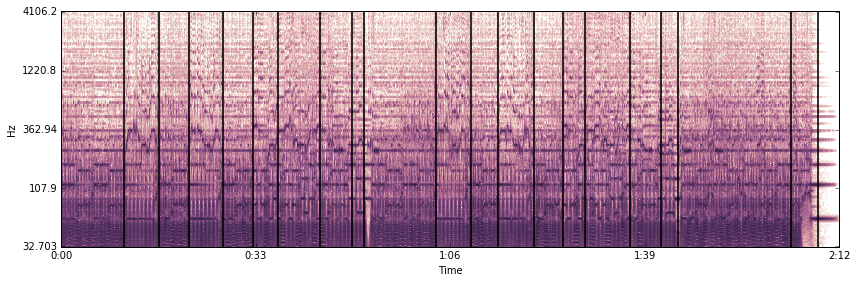

In [79]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr, bins_per_octave=12*3, x_axis='time')
plt.vlines(bound_frames, -0.5, C.shape[0] - 0.5, color='black', linewidth=2, alpha=0.8)
plt.tight_layout()